In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모델

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, multiply, Cropping1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

def build_mcnn_model(input_shape):
    input_layer = Input(shape=input_shape)  # (80, 4)

    # Encoder1: 단순 CNN
    x1 = Conv1D(filters=50, kernel_size=16, strides=2, padding='valid', activation='tanh')(input_layer)
    x1 = Conv1D(filters=30, kernel_size=8, strides=2, padding='valid', activation='tanh')(x1)
    x1 = MaxPooling1D(pool_size=2, padding='valid')(x1)  # (None, 6, 30)

    # Encoder2: 복잡 CNN
    x2 = Conv1D(filters=50, kernel_size=6, strides=1, padding='valid', activation='tanh')(input_layer)
    x2 = Conv1D(filters=40, kernel_size=6, strides=1, padding='valid', activation='tanh')(x2)
    x2 = MaxPooling1D(pool_size=2, padding='valid')(x2)
    x2 = Conv1D(filters=30, kernel_size=6, strides=1, padding='valid', activation='tanh')(x2)
    x2 = Conv1D(filters=30, kernel_size=6, strides=2, padding='valid', activation='tanh')(x2)
    x2 = MaxPooling1D(pool_size=2, padding='valid')(x2)  # (None, 6, 30)

    # 길이 확인
    print("x1 shape:", x1.shape)
    print("x2 shape:", x2.shape)

    # multiply 병합
    merged = multiply([x1, x2])

    ## LSTM ##
    lstm = LSTM(64, return_sequences=False)(merged)  # or return_sequences=True if stacking
    dropout = Dropout(0.3)(lstm)

    # 출력층 (잔존 수명 예측: 회귀 문제 → 1차원 출력)
    output = Dense(1, activation='linear')(dropout)

    # 모델 정의
    model = Model(inputs=input_layer, outputs=output)
    return model


## 데이터 불러오기

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# CSV 불러오기
csv_path = "/content/train1_extracted_features_with_rul.csv"
df = pd.read_csv(csv_path)

# 입력 (X), 라벨 (y) 분리
X = df.drop(columns=["RUL"]).values  # shape: (samples, features)
y = df["RUL"].values  # shape: (samples,)

# 3D 형태로 변환 (MCNN용): (samples, time steps, channels)
# 예: time_steps = 80, channels = 4  → 320개 feature일 경우
X_reshaped = X.reshape(X.shape[0], 80, 4)

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# y의 shape을 (N, 1)로 변경 (회귀 모델의 출력과 맞춤)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [4]:
print("X_train shape:", X_train.shape)  # 예상: (N, 80, 4)
print("y_train shape:", y_train.shape)  # 예상: (N, 1)

X_train shape: (1503, 80, 4)
y_train shape: (1503, 1)


## 모델 학습

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_mcnn_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

x1 shape: (None, 6, 30)
x2 shape: (None, 6, 30)
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1180190.5000 - mae: 942.1583 - val_loss: 1133581.2500 - val_mae: 908.7778
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1142483.2500 - mae: 920.7441 - val_loss: 1126026.6250 - val_mae: 904.7159
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1156643.2500 - mae: 930.4487 - val_loss: 1119698.0000 - val_mae: 901.3040
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1161438.0000 - mae: 938.6842 - val_loss: 1113721.2500 - val_mae: 898.0694
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1128781.1250 - mae: 913.9237 - val_loss: 1108026.5000 - val_mae: 894.9929
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1118958.2500 - mae: 909.9828 - val_loss: 1102366.6250 - val_mae: 891.9246
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1117496.7500 - mae: 912.4693 - val_loss: 1096836.6250 - val_mae: 888.9164
Epoch 8/50
47/47 ━━━━

## 학습 확인

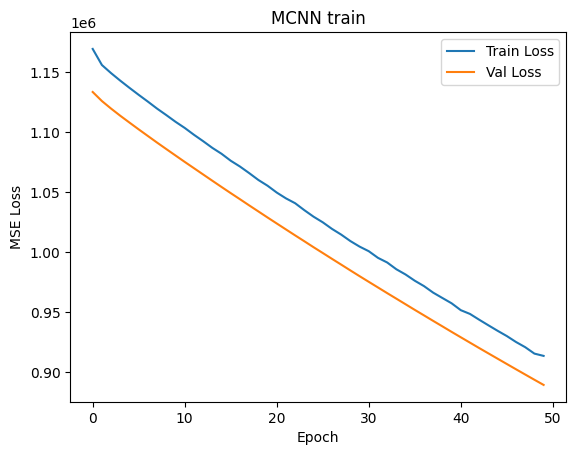

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('MCNN train')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## 모델 평가